In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

file_path = "data/cocktail_dataset.json"  
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

cocktails = []
for drink in data:
    for ingredient in drink["ingredients"]:
        cocktails.append({
            "cocktail_id": drink["id"],
            "cocktail_name": drink["name"],
            "category": drink["category"],
            "glass": drink["glass"],
            "alcoholic": drink["alcoholic"],
            "ingredient": ingredient["name"],
            "ingredient_type": ingredient.get("type", "Unknown"),
            "measure": ingredient.get("measure", "Unknown")
        })

df = pd.DataFrame(cocktails)
df.head()


,cocktail_id,cocktail_name,category,glass,alcoholic,ingredient,ingredient_type,measure
0,11000,Mojito,Cocktail,Highball glass,1,Soda water,None,Unknown
1,11000,Mojito,Cocktail,Highball glass,1,Light Rum,Rum,2-3 oz
2,11000,Mojito,Cocktail,Highball glass,1,Lime,Fruit,Juice of 1
3,11000,Mojito,Cocktail,Highball glass,1,Mint,Flower,2-4
4,11000,Mojito,Cocktail,Highball glass,1,Sugar,None,2 tsp


Liczba unikalnych koktajli: 134
Liczba unikalnych składników: 102


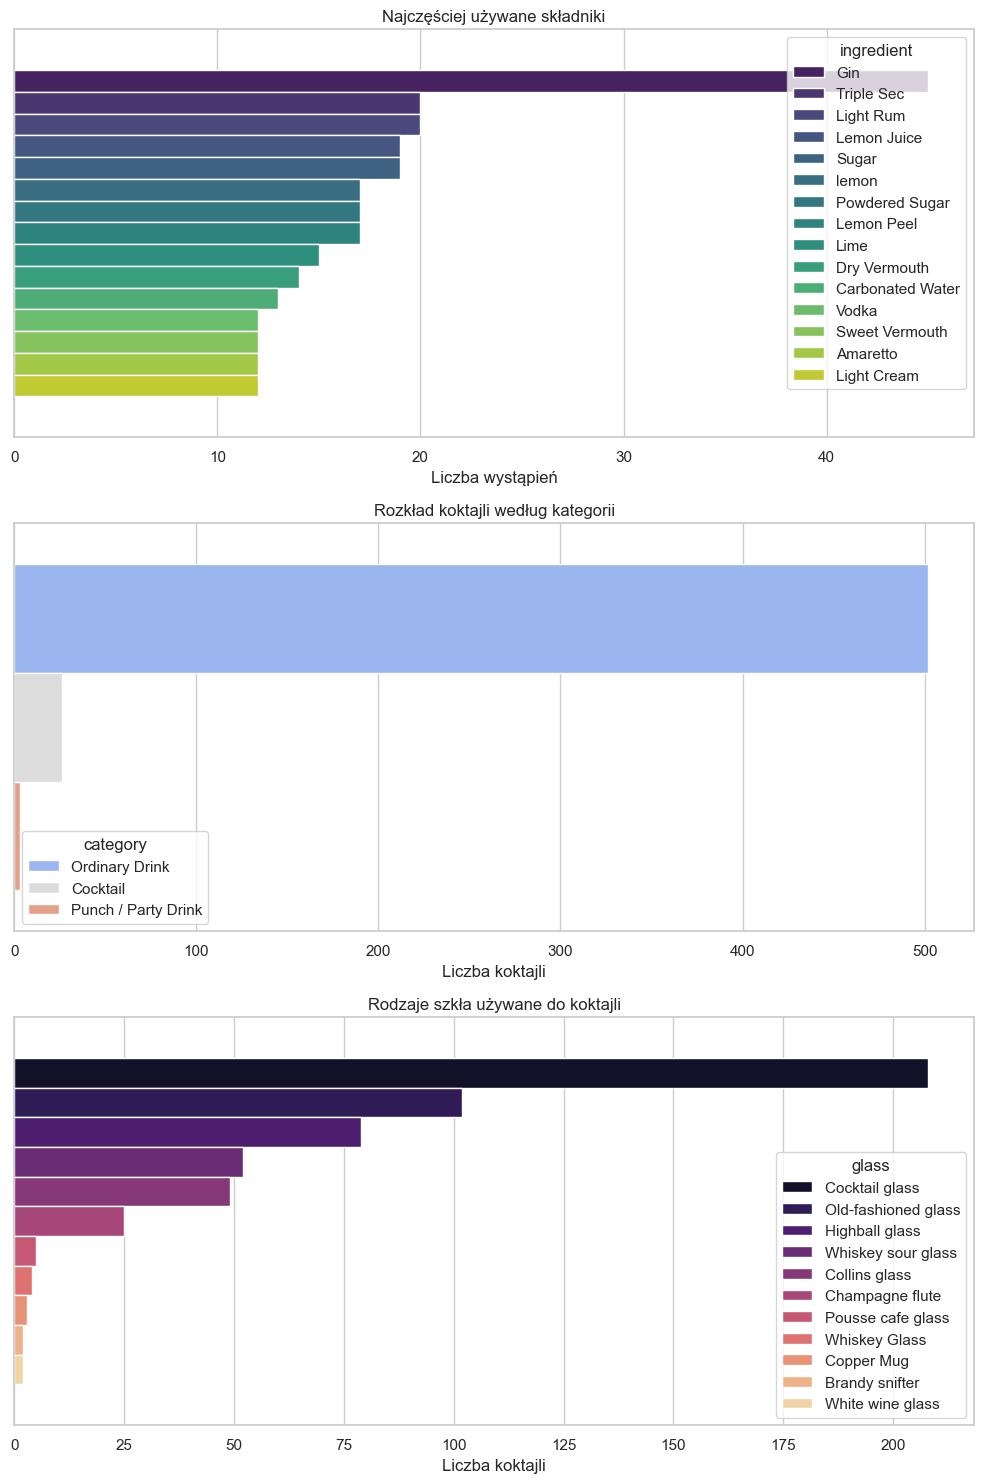

In [17]:
num_cocktails = df["cocktail_name"].nunique()
num_ingredients = df["ingredient"].nunique()
print(f"Liczba unikalnych koktajli: {num_cocktails}")
print(f"Liczba unikalnych składników: {num_ingredients}")

top_ingredients = df["ingredient"].value_counts().head(15)

category_counts = df["category"].value_counts()
glass_counts = df["glass"].value_counts()

sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.barplot(hue=top_ingredients.index, x=top_ingredients.values, ax=axes[0], palette="viridis")
axes[0].set_title("Najczęściej używane składniki")
axes[0].set_xlabel("Liczba wystąpień")

sns.barplot(hue=category_counts.index, x=category_counts.values, ax=axes[1], palette="coolwarm")
axes[1].set_title("Rozkład koktajli według kategorii")
axes[1].set_xlabel("Liczba koktajli")

sns.barplot(hue=glass_counts.index, x=glass_counts.values, ax=axes[2], palette="magma")
axes[2].set_title("Rodzaje szkła używane do koktajli")
axes[2].set_xlabel("Liczba koktajli")

plt.tight_layout()
plt.show()


In [18]:
pivot_df = df.pivot_table(index="cocktail_name", columns="ingredient", aggfunc="size", fill_value=0)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
pivot_df["cluster"] = kmeans.fit_predict(pivot_df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivot_df.drop(columns=["cluster"]))

df_clusters = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
df_clusters["cluster"] = pivot_df["cluster"].values
df_clusters["cocktail_name"] = pivot_df.index

df = df.merge(df_clusters[["cocktail_name", "cluster"]], on="cocktail_name")
df.head()


,cocktail_id,cocktail_name,category,glass,alcoholic,ingredient,ingredient_type,measure,cluster
0,11000,Mojito,Cocktail,Highball glass,1,Soda water,None,Unknown,2
1,11000,Mojito,Cocktail,Highball glass,1,Light Rum,Rum,2-3 oz,2
2,11000,Mojito,Cocktail,Highball glass,1,Lime,Fruit,Juice of 1,2
3,11000,Mojito,Cocktail,Highball glass,1,Mint,Flower,2-4,2
4,11000,Mojito,Cocktail,Highball glass,1,Sugar,None,2 tsp,2


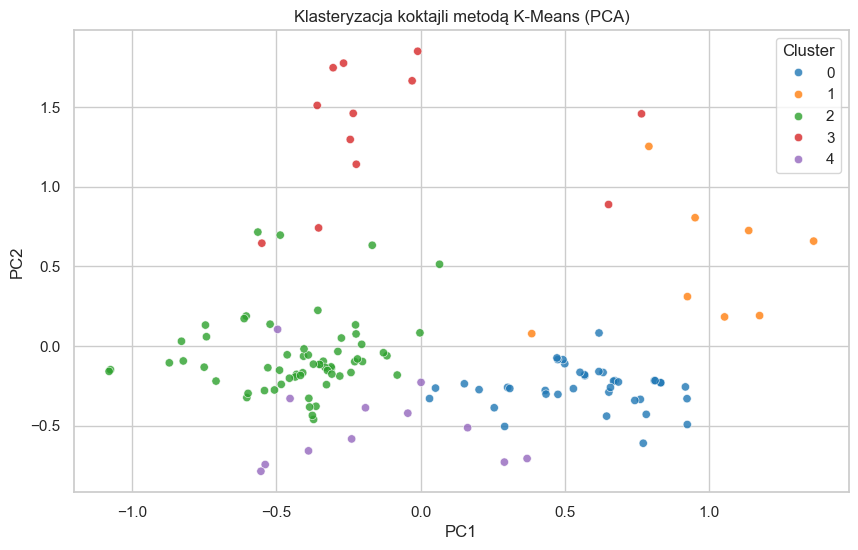

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clusters, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.8)
plt.title("Klasteryzacja koktajli metodą K-Means (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


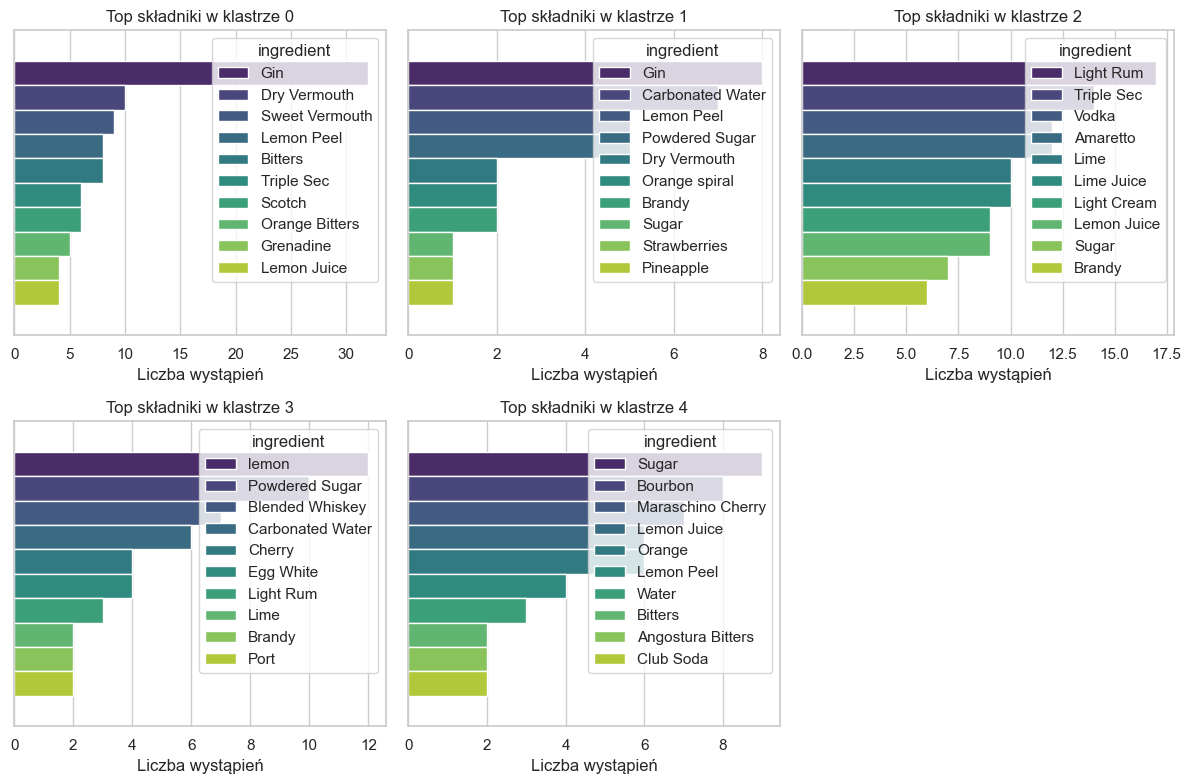

In [20]:
plt.figure(figsize=(12, 8))
for cluster in range(5):
    plt.subplot(2, 3, cluster + 1)
    top_ingredients = df[df["cluster"] == cluster]["ingredient"].value_counts().head(10)
    sns.barplot(hue=top_ingredients.index, x=top_ingredients.values, palette="viridis")
    plt.title(f"Top składniki w klastrze {cluster}")
    plt.xlabel("Liczba wystąpień")
plt.tight_layout()
plt.show()


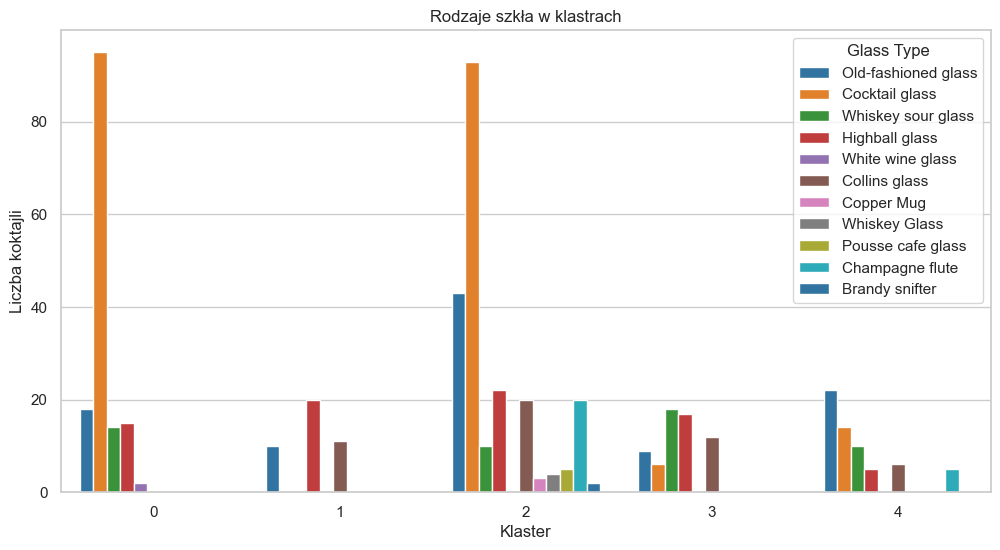

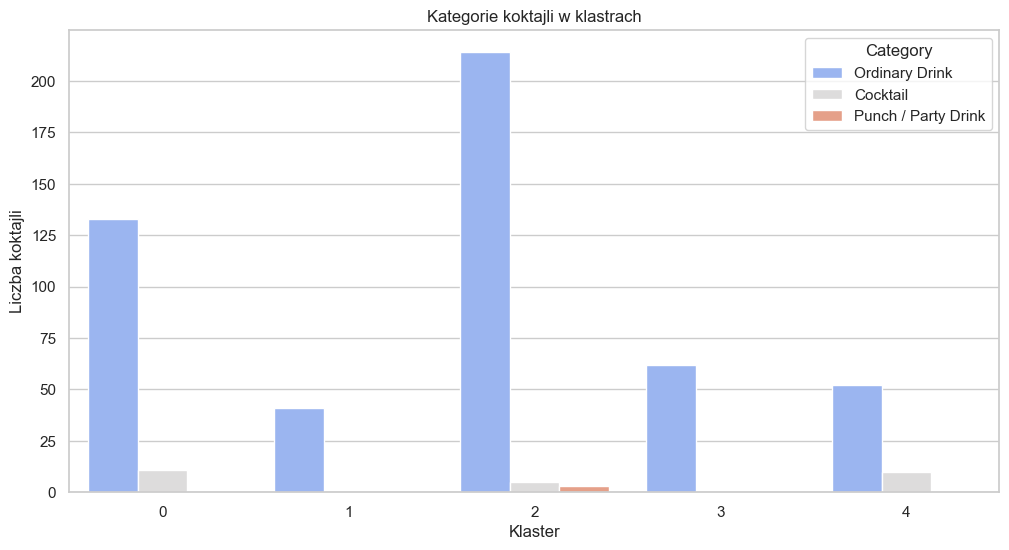

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="cluster", hue="glass", palette="tab10")
plt.title("Rodzaje szkła w klastrach")
plt.xlabel("Klaster")
plt.ylabel("Liczba koktajli")
plt.legend(title="Glass Type", bbox_to_anchor=(1, 1))
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="cluster", hue="category", palette="coolwarm")
plt.title("Kategorie koktajli w klastrach")
plt.xlabel("Klaster")
plt.ylabel("Liczba koktajli")
plt.legend(title="Category", bbox_to_anchor=(1, 1))
plt.show()


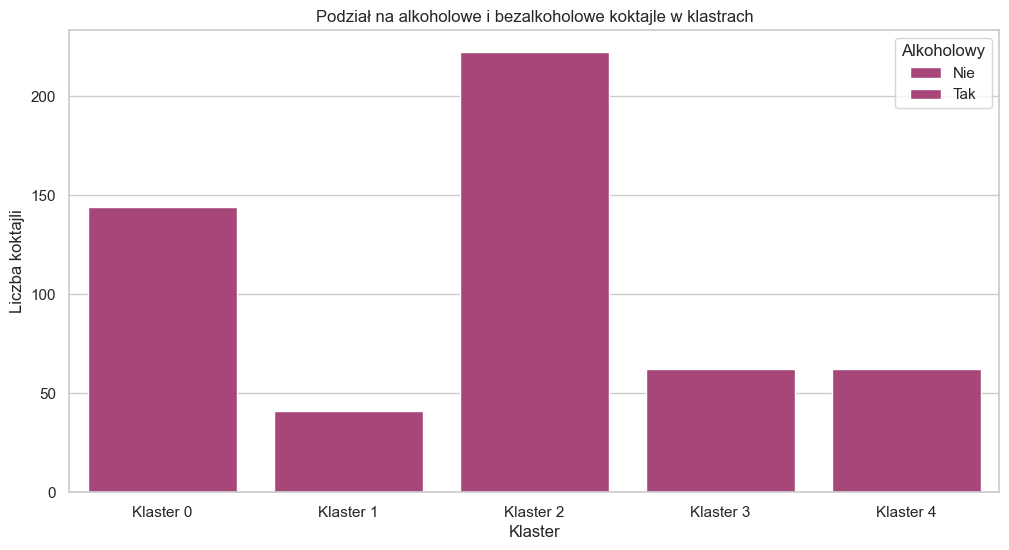

In [22]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="cluster", hue="alcoholic", palette="magma")
plt.title("Podział na alkoholowe i bezalkoholowe koktajle w klastrach")
plt.xlabel("Klaster")
plt.ylabel("Liczba koktajli")
plt.xticks(ticks=range(5), labels=[f"Klaster {i}" for i in range(5)])
plt.legend(title="Alkoholowy", labels=["Nie", "Tak"])
plt.show()


In [23]:
for cluster in range(5):
    print(f"\n Klaster {cluster}:")
    print("Najczęściej używane składniki:")
    print(df[df["cluster"] == cluster]["ingredient"].value_counts().head(5))
    print("\nRodzaj szkła:")
    print(df[df["cluster"] == cluster]["glass"].value_counts().head(3))
    print("\nKategorie koktajli:")
    print(df[df["cluster"] == cluster]["category"].value_counts().head(3))
    print("\nPodział alkoholowy:")
    print(df[df["cluster"] == cluster]["alcoholic"].value_counts(normalize=True).map(lambda x: f"{x:.0%}"))



 Klaster 0:
Najczęściej używane składniki:
ingredient
Gin               32
Dry Vermouth      10
Sweet Vermouth     9
Lemon Peel         8
Bitters            8
Name: count, dtype: int64

Rodzaj szkła:
glass
Cocktail glass         95
Old-fashioned glass    18
Highball glass         15
Name: count, dtype: int64

Kategorie koktajli:
category
Ordinary Drink    133
Cocktail           11
Name: count, dtype: int64

Podział alkoholowy:
alcoholic
1    100%
Name: proportion, dtype: object

 Klaster 1:
Najczęściej używane składniki:
ingredient
Gin                 8
Carbonated Water    7
Lemon Peel          5
Powdered Sugar      5
Dry Vermouth        2
Name: count, dtype: int64

Rodzaj szkła:
glass
Highball glass         20
Collins glass          11
Old-fashioned glass    10
Name: count, dtype: int64

Kategorie koktajli:
category
Ordinary Drink    41
Name: count, dtype: int64

Podział alkoholowy:
alcoholic
1    100%
Name: proportion, dtype: object

 Klaster 2:
Najczęściej używane składniki:
ingred